# DATA EXPLORATION


In [2]:
# IMPORTS AND SEED SETTING

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



torch.manual_seed(33)  


In [3]:

ratingsRaw = pd.read_csv("ml-100k/u.data", sep = "\t", header = None, names=["userId", "movieId", "rating", "timestamp"]) 

ratingsRaw.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:

# Define column names based on the MovieLens 100k dataset  (check the README)
column_names = [
    "movieId", "movie title", "release date", "video release date", "IMDb URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]  

# Read the dataset with the correct separator (|)  
movies = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None, names=column_names)  

# Display the first few rows  
movies.head()




,movieId,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:

# Function to translate from movie id to movie title
def idToTitle(movie_id):
    # Filter the movies DataFrame where movieId matches and return the title
    movie = movies[movies['movieId'] == movie_id]['movie title'].values
    # Return the first match (or None if no match found)
    return movie[0] if len(movie) > 0 else None

# Example usage
movie_title = idToTitle(1)
print(f"Movie with ID 1: {movie_title}")

Movie with ID 1: Toy Story (1995)


It is important to check that the distribution of the ID's is sequential. So that we do not confuse the model and make more inneficient.


In [6]:


print("Min User ID:", ratingsRaw["userId"].min(),  "    |    Max User ID:", ratingsRaw["userId"].max())
print("Min Movie ID:", ratingsRaw["movieId"].min(),"   |    Max Movie ID:", ratingsRaw["movieId"].max())

print("n")

print("Unique User IDs:", len(ratingsRaw["userId"].unique()))
print("Unique Movie IDs:", len(ratingsRaw["movieId"].unique()))


Min User ID: 1     |    Max User ID: 943
Min Movie ID: 1    |    Max Movie ID: 1682
n
Unique User IDs: 943
Unique Movie IDs: 1682


In [7]:
print("Shape of ratings dataset:",ratingsRaw.shape)


Shape of ratings dataset: (100000, 4)


### Divide the dataset into training, validation and test

In [8]:

# Convert to Pandas DataFrame for splitting
train_data, test_data = train_test_split(ratingsRaw, test_size=0.2, random_state=33)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=33)  # 10% of training as validation


## DATASET 

In [9]:

class MovieLensDataset(Dataset):
    def __init__(self, ratings_df):
        
        self.ratings = ratings_df

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        row = self.ratings.iloc[idx]
        user_id = torch.tensor(row["userId"], dtype=torch.long)   
        movie_id = torch.tensor(row["movieId"], dtype=torch.long)   
        rating = torch.tensor(row["rating"], dtype=torch.float32)
        return user_id, movie_id, rating



# Convert splits back to Dataset format
train_dataset = MovieLensDataset(train_data)
val_dataset = MovieLensDataset(val_data)
test_dataset = MovieLensDataset(test_data)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Check a batch
for batch in train_loader:
    u, m, r = batch
    print("First 5 users:", u[:5])
    print("First 5 mapped movies:", m[:5])
    print("First 5 ratings:", r[:5])
    
    
    break


First 5 users: tensor([239, 125, 506, 186, 360])
First 5 mapped movies: tensor([650, 163, 604, 303, 269])
First 5 ratings: tensor([5., 5., 4., 3., 4.])


# BUILD THE MODEL

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=32):
        super(RecommenderNN, self).__init__()

        # Embedding layers for users and movies
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

        # Feedforward layers
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output is a single predicted rating

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, user_ids, movie_ids):
        # Get embeddings
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)

        # Concatenate user and movie embeddings
        x = torch.cat([user_embeds, movie_embeds], dim=1)

        # Forward pass through feedforward layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output raw prediction

        return x.squeeze()  # Remove extra dimension


In [11]:
num_users = num_movies = len(ratingsRaw) 


# Initialize the model
model = RecommenderNN(num_users, num_movies, embedding_dim=32)

criterion = nn.MSELoss()  # Regression task
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1/50, Train Loss: 1.4173, Val Loss: 1.0670
Epoch 2/50, Train Loss: 1.0680, Val Loss: 0.9850
Epoch 3/50, Train Loss: 0.9939, Val Loss: 0.9455
Epoch 4/50, Train Loss: 0.9521, Val Loss: 0.9532
Epoch 5/50, Train Loss: 0.9236, Val Loss: 0.9088
Epoch 6/50, Train Loss: 0.9014, Val Loss: 0.9034
Epoch 7/50, Train Loss: 0.8909, Val Loss: 0.8955
Epoch 8/50, Train Loss: 0.8758, Val Loss: 0.9016
Epoch 9/50, Train Loss: 0.8666, Val Loss: 0.8961
Epoch 10/50, Train Loss: 0.8574, Val Loss: 0.8910
Epoch 11/50, Train Loss: 0.8476, Val Loss: 0.8819
Epoch 12/50, Train Loss: 0.8380, Val Loss: 0.8746
Epoch 13/50, Train Loss: 0.8269, Val Loss: 0.8860
Epoch 14/50, Train Loss: 0.8214, Val Loss: 0.9074
Epoch 15/50, Train Loss: 0.8092, Val Loss: 0.8930
Epoch 16/50, Train Loss: 0.7997, Val Loss: 0.8915
Epoch 17/50, Train Loss: 0.7894, Val Loss: 0.8885
Early stopping triggered at epoch 17. Best Validation Loss: 0.8746


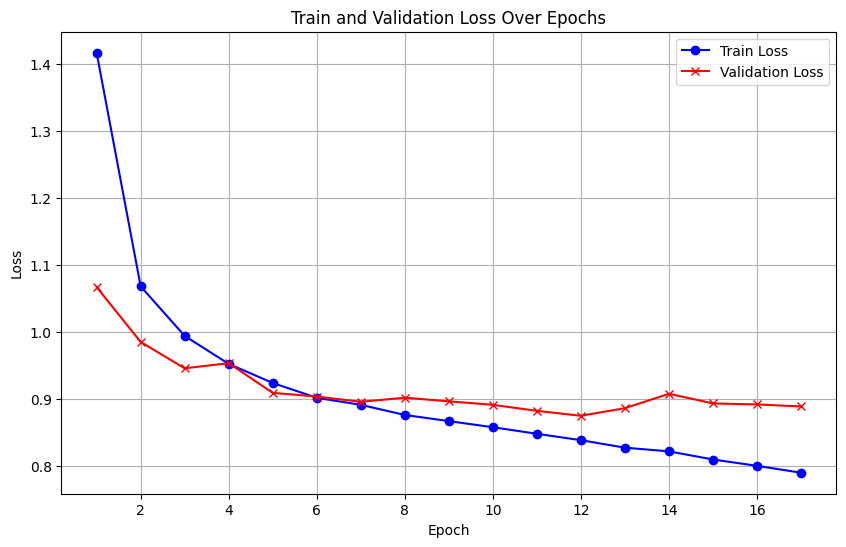

In [12]:
import matplotlib.pyplot as plt

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop with Early Stopping
num_epochs = 50  # Max epochs (can be large since early stopping will prevent overfitting)
patience = 5     # Number of epochs to wait before stopping
best_val_loss = float('inf')
patience_counter = 0

# Lists to store the loss values for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for user_ids, movie_ids, ratings in train_loader:
        user_ids, movie_ids, ratings = user_ids.to(device), movie_ids.to(device), ratings.to(device)

        optimizer.zero_grad()
        predictions = model(user_ids, movie_ids)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation step (NO gradient update)
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user_ids, movie_ids, ratings in val_loader:
            user_ids, movie_ids, ratings = user_ids.to(device), movie_ids.to(device), ratings.to(device)
            predictions = model(user_ids, movie_ids)
            loss = criterion(predictions, ratings)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    # Append losses to the lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter
        torch.save(model, "basicModel.pth")  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
        break  # Stop training

# Plotting the train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red', linestyle='-', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Test set evaluation

In [13]:
model.eval()  # Set model to evaluation mode
total_test_loss = 0

for user_ids, movie_ids, ratings in test_loader:
    user_ids, movie_ids, ratings = user_ids.to(device), movie_ids.to(device), ratings.to(device)

    predictions = model(user_ids,movie_ids)
    loss = criterion(predictions, ratings)
    total_test_loss += loss.item()

print(f"MSE for test set: {total_test_loss/len(test_loader):.4f}")

MSE for test set: 0.9332


## Reccomendation example

In [82]:
def getTop5fromUser(userID):
    # Get all ratings for the user
    user_ratings = ratingsRaw[ratingsRaw["userId"] == userID]
    
    # Sort by rating column in descending order
    sorted_ratings = user_ratings.sort_values(by='rating', ascending=False)
    
    # Return top 5 ratings
    return list(sorted_ratings.head(5)["movieId"].apply(idToTitle))

# Test the function
getTop5fromUser(11)

['Boys on the Side (1995)',
 'Last Supper, The (1995)',
 'Dead Man Walking (1995)',
 'Chasing Amy (1997)',
 'Day the Earth Stood Still, The (1951)']

In [14]:
def predict_rating(model, user_id, movie_id):
    # Set model to evaluation mode
    model.eval()
    
    # Convert IDs to tensors
    user = torch.tensor([user_id], dtype=torch.long)
    movie = torch.tensor([movie_id], dtype=torch.long)
    
    # Get prediction
    with torch.no_grad():
        prediction = model(user, movie)
    
    # Convert prediction to rating scale
    predicted_rating = prediction.item()
    
    # Get movie title for better context
    movie_title = idToTitle(movie_id)
    
    return predicted_rating
    
    print(f"Predicted rating for User {user_id} watching '{movie_title}': {predicted_rating:.2f}")

 

In [ ]:
def getRecommnedationsForUser(userID):
    
    ratedMovies = {}
    
    for movie_id in np.unique(ratingsRaw["movieId"]):
        rating = predict_rating(model, userID, movie_id)
        ratedMovies[idToTitle(movie_id)] = rating
        
    sorted_movies = dict(sorted(ratedMovies.items(), key=lambda item: item[1], reverse=True)[:5])
    print("Reccomendations for User with ID =",userID)
    print("Current user top 5:",getTop5fromUser(userID).value())
    print("..............................................")
    for movie in sorted_movies:
        print(f"{movie}, {sorted_movies[movie]:.2f}")

In [88]:
getRecommnedationsForUser(11)

Reccomendations for User with ID = 11


TypeError: list.extend() takes exactly one argument (0 given)

In [71]:
getRecommnedationsForUser(22)

Reccomendations for User with ID = 22
..............................................
Citizen Kane (1941), 4.60
Pather Panchali (1955), 4.60
Shall We Dance? (1996), 4.58
Big Bang Theory, The (1994), 4.57
Entertaining Angels: The Dorothy Day Story (1996), 4.54


In [72]:
getRecommnedationsForUser(33)

Reccomendations for User with ID = 33
..............................................
Saint of Fort Washington, The (1993), 5.42
Schindler's List (1993), 5.15
Anna (1996), 5.09
Big Bang Theory, The (1994), 5.06
Shall We Dance? (1996), 5.04


## LOAD THE MODEL

In [20]:
model = torch.load("basicModel.pth",weights_only=False)